# Introduction

In the previous notebook, value padding was considered as solution for unequal signal length. Here, sensors are going to be split into two groups: *heating sensors* and *forging sensors*, depending on the role of each sensor in the production process. For heating sensors, only *heating phase* from time signals is going to be observed, and for the forging sensors, principle is the same, but with *forging phase*. 

The workflow of this and other notebooks is presented on the image below:
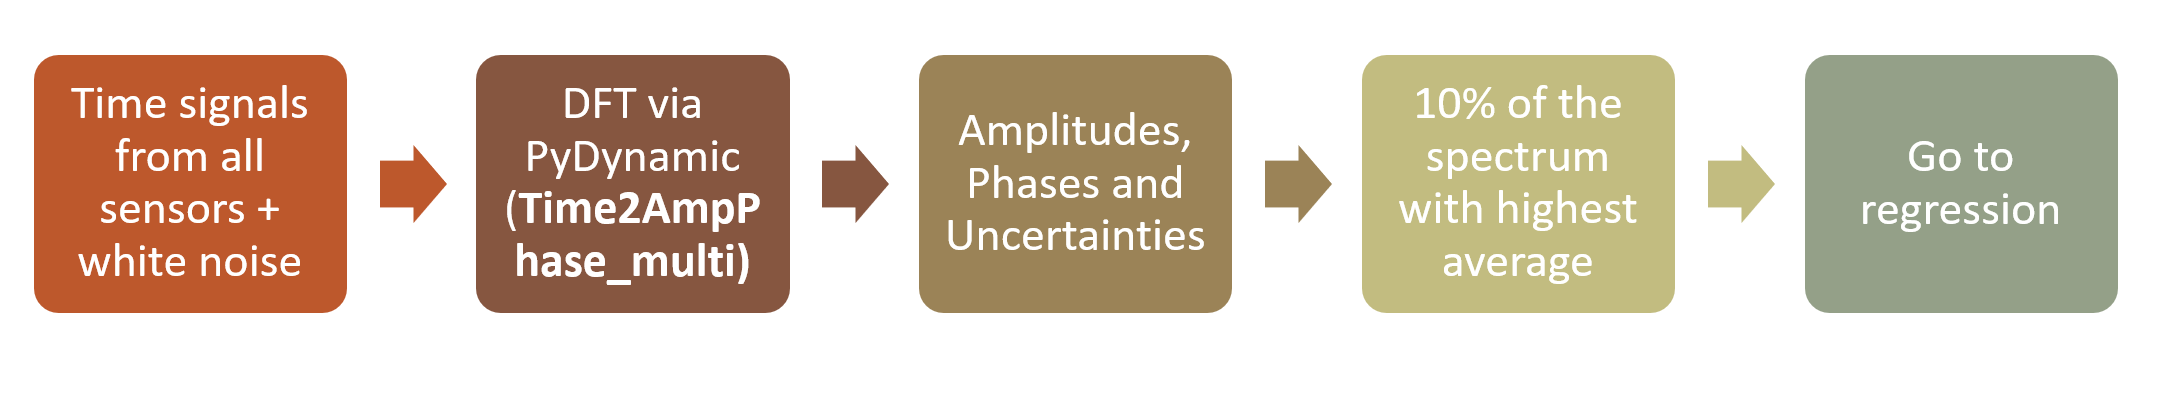

First step will be to examine if some other sensors can be also considered as relevant sensors for some production phase. This will be conducted for only one part because the same process is repeated for all other parts.

In [ ]:
import pandas as pd 
import time
%pip install openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
np.random.seed(42)
from scipy.signal import find_peaks
from scipy import integrate
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from matplotlib._png import read_png
from matplotlib.cbook import get_sample_data
import PyDynamic
from PyDynamic.uncertainty.propagate_DFT import GUM_DFT,DFT2AmpPhase,Time2AmpPhase_multi

font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

# 1 Relevant sensors

List `data` with length of 81 is containing matrix for each part, where columns are time series from sensors measurements. Column names are names of sensors, and row indices are samples numbers.

In [ ]:
data=[0]*81
for i in range(81):
    print("|"*(i+1),(i+1), end="\r")
    file_format="Scope"+str("{:04d}".format(i+1))+".csv"    
    data[i] = pd.read_csv(Path('Data')/'AFRC Radial Forge - Zenodoo Upload v3'/'Data'/'ScopeTraces'/file_format.format(i), header=0, encoding = 'unicode_escape')#, index_col=0)
    time.sleep(1)

Looking at column names of imported data gives us insight into sensors used for this measurement:

In [ ]:
data[0].head()

Concatenating the data from all part will make one long time series. Index will be recreated, and timeline will be adjusted. Before concatenating part labels will be added.

In [ ]:
for index,df in enumerate(data):
    df['traceID'] = index+1

In [ ]:
merged_data = pd.concat(data, ignore_index=True)
merged_data['Time [s]']=(merged_data.index.values)/100.0

Now, we will have a look in data for only one part, because for other parts production cycle consists of the same phases.

In [ ]:
merged_data.iloc[0:23328].to_excel("Merged_data_from_1st_sensor.xlsx")

In [ ]:
first_sensor=pd.read_excel("Merged_data_from_1st_sensor.xlsx")

Sensors that are not in use or are the part of auxiliary process measurement will be dropped:   

In [ ]:
used_sensors=first_sensor.drop(['hydraulic low pressure [bar]','hydraulic high pressure [bar]','A_NOM_Force [kN]','B_ACTpos [mm]','B_ACT_Force [kN]',"B_ACTspd [mm/min]","B_NOMpos [mm]","B_OUT [%]","B_NOMspd [mm/min]","B_NOM_Force [kN]","Feedback B [%]","DB_NOM_Force [kN]","D_ACTpos [mm]","D_ACT_Force [kN]","D_ACTspd [mm/min]","D_NOMpos [mm]","D_OUT [%]","D_NOMspd [mm/min]","D_NOM_Force [kN]", "Feedback D [%]","Lub_ActSpd [rpm]","Hyd_ActSpd [rpm]","O_EMERG","STP || EM","O_MASTOP","$U_GH_NOMVAL_1 (U25W1)","$H1P_Y12 (U11S17)","$H1P_Y11 (U11S7)","$U_GH_NOMEXT_2 (U26S1)","$U_GH_HEATON_2 (U26S0)","$U_GH_NOMEXT_1 (U25S1)"],axis=1)

We can have a look into rest of the data:

In [ ]:
%matplotlib inline
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,15)
mpl.rc('font', **font)

def overview(num_of_sensor):
    names=list(used_sensors.columns.values)
    plt.plot(used_sensors['Time [s]'],used_sensors[names[num_of_sensor+3]])
    plt.xlabel('Time [s]')
    plt.title(names[num_of_sensor+3])
    plt.ylabel('Values');
interact(overview,num_of_sensor=widgets.IntSlider(min=0, max=99, step=1))

Sensors chosen as relevant sensors for specific production phase (heating/transfer/forging) in *Strathcylde_AFRC_machine_learning_tutorials* as well as those which had been dropped as non - relevant will not be considered in the next plot. Only the rest of the sensors will be analyzed.

In [ ]:
other_sensors=used_sensors.drop(['Schlagzahl [1/min]',"Power [kW]","Force [kN]","A_ACT_Force [kN]","A_NOMpos [mm]","A_ACTpos [mm]","DB_ACT_Force [kN]","SBA_ActPos [mm]","IP_ActPos [mm]","IP_NomPos","TMP_Ind_U1 [°C]","TMP_Ind_F [°C]","L_ACTpos [mm]","L_NOMpos [mm]","R_ACTpos [mm]","R_NOMpos [mm]","EXZ_pos [deg]",'A_ACTspd [mm/min]','A_NOMspd [mm/min]','A_OUT [%]','Feedback A [%]','DB_ACTpos [mm]','DB_ACTspd [mm/min]','DB_NOMpos [mm]','DB_OUT [%]','DB_NOMspd [mm/min]','Feedback DB [%]','L_ACTspd [mm/min]','L_OUT [%]','L_NOMspd [mm/min]','Feedback L [%]','R_ACTspd [mm/min]','R_OUT [%]','R_NOMspd [mm/min]','Feedback R [%]','SBA_NomPos [mm] [mm]','SBA_OUT [%]','Feedback SBA [%]',"ForgingBox_Temp","$U_GH_HEATON_1 (U25S0).1"],axis=1)

In [ ]:
%matplotlib inline
font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,5)
mpl.rc('font', **font)
def overview_other_sensors(num_of_sensor):
   
    plt.plot(other_sensors['Time [s]'], other_sensors[[num_of_sensor]])
    plt.xlabel('Time [s]')
    plt.title(num_of_sensor)
    plt.ylabel('Values');
interact(overview_other_sensors,num_of_sensor=list(other_sensors.columns[3:].values))

Based on the plot, additional sensors that will be considered are:
- A_ges_vibr
- INDA_NOMpos [deg]
- FRC_Volt
- RamRetract_ActSpd [rpm]
- W1 Durchfluss [I]
- W2 Durchfluss [I]
- L1.R_B41 (bar)

In [ ]:
other_sensors.columns.values

In [ ]:
used_sensors=used_sensors.drop(['EXZ_pos [deg]','DB_ACTpos [mm]',"IP_ActSpd [mm/min]","IP_NomSpd [mm/min]",'INDA_ACTpos [deg]','INDA_NOMspd [U/min]','INDA_OUT [%]','INDA_ACTspd [U/min]',
       'Speed Vn_1 [rpm]', 'NOMforceSPA [kN]', '$F_F41L (I14S8)','SPA_OUT [%]','Feedback_SPA [%]','IP_Out [%]',
       'ACTforceSPA [kN]', '$U_GH_HEATON_1 (U25S0)','$E_GH_FAULT_2 (I26S21)','L_ACTspd [mm/min]',
       'R_ACTspd [mm/min]', 'SBA_NomPos [mm] [mm]', 'A_ACTspd [mm/min]',
       'DB_ACTspd [mm/min]','SBA_OUT [%]', 'DB_NOMpos [mm]', 'L_OUT [%]', 'R_OUT [%]', 'Feedback SBA [%]',
       'A_OUT [%]', 'DB_OUT [%]', 'L_NOMspd [mm/min]',
       'R_NOMspd [mm/min]','A_NOMspd [mm/min]',"Feedback A [%]",
       'Feedback DB [%]','DB_NOMspd [mm/min]', 'Feedback L [%]', 'Feedback R [%]','$E_GH_FAULT_1 (I25S21)', '$B12R_Y11 (U14S16)', 'Unnamed: 0','c01w', 'c02w', 'Timer Tick [ms]', 'Block-Nr','traceID','Time [s]', '$U_GH_HEATON_1 (U25S0).1'],axis=1)

Total number of sensors which will be analyzed is:

In [ ]:
len(used_sensors.columns)

and they are:

In [ ]:
used_sensors.columns.values

## 1.2 Splitting sensors into two groups

Two sensors indicate the start and the end of heating and forging phases. The signal `$U_GH_HEATON_1 (U25S0).1` indicates when the induction heater switches on and off. *Forging* phase is active when force sensor (`Force [kN]`) is greater than zero.

In [ ]:
digital_sig_heating = merged_data['$U_GH_HEATON_1 (U25S0).1']>0
heating_diff = digital_sig_heating.astype('int').diff()

digital_sig_forge = merged_data['Force [kN]']>0
forge_diff = digital_sig_forge.astype('int').diff()

In [ ]:
heating_start=heating_diff[heating_diff==1].index.values
heating_stop=heating_diff[heating_diff==-1].index.values

The following sensors are relevant for the heating phase:

In [ ]:
heating_sensors=used_sensors[['TMP_Ind_U1 [°C]','IP_ActPos [mm]', 'IP_NomPos']]

In [ ]:
heating_ph=[None]*81
for i in range(len(heating_ph)):
    heating_ph[i]=merged_data[heating_sensors.columns.values][heating_start[i]:heating_stop[i]].copy()
    print(heating_ph[i].shape)

Rows in *heating_ph[i]* are representing duration of the heating phase and it can be seen that it is very similar for all of 81 parts. Because of this, the minimum length of time signals is going to be extracted for all sensors and all cycles (parts).

In [ ]:
cycle_length_heat=[None]*(len(heating_ph))
for i in range(len(heating_ph)):
    cycle_length_heat[i]=(heating_ph[i].shape[0])

In [ ]:
min_length_heat=min(cycle_length_heat)
print("Minimum length of time signals  for the heating phase is :",min_length_heat, "and it is in",cycle_length_heat.index(min_length_heat),". cycle")

In [ ]:
heating_sensors_min=[None]*(heating_ph[0].shape[1])
for p in range (heating_ph[0].shape[1]):
    heating_sensors_min[p] = np.zeros((len(heating_ph),min_length_heat))
    for k in range(len(heating_ph)):
             heating_sensors_min[p][k]=heating_ph[k].iloc[:10997,p].values

In [ ]:
heating_sensors_min[0].shape

The following sensors are relevant for the forging phase:

In [ ]:
forging_sensors=used_sensors[['Power [kW]', 'Force [kN]', 'A_ges_vibr','Schlagzahl [1/min]', 'RamRetract_ActSpd [rpm]',
       'A_ACTpos [mm]', 'L_ACTpos [mm]', 'R_ACTpos [mm]',
       'SBA_ActPos [mm]', 'A_ACT_Force [kN]', 'DB_ACT_Force [kN]',
       'L_NOMpos [mm]', 'R_NOMpos [mm]', 'INDA_NOMpos [deg]',
       'A_NOMpos [mm]', 'Frc_Volt','ForgingBox_Temp', 'L1.R_B41 [bar]', 'TMP_Ind_F [°C]','W2 Durchfluss [l]', 'W1 Durchfluss [l]']]

In [ ]:
forging_ph=[None]*81
for i in range(len(forging_ph)):
    forging_ph[i]=merged_data[forging_sensors.columns.values][forge_diff[forge_diff==1].index.values[i]:forge_diff[forge_diff==-1].index.values[i]].copy()
    print(forging_ph[i].shape)

Rows in *forging_ph[i]* are representing duration of the forging phase and it can be seen that it is very similar for all of 81 parts. Because of this, the minimum length of time signals is going to be extracted for all sensors and all cycles (parts).

In [ ]:
cycle_length_forge=[None]*(len(forging_ph))
for i in range(len(forging_ph)):
    cycle_length_forge[i]=(forging_ph[i].shape[0])

In [ ]:
min_length_forge=min(cycle_length_forge)
print("Minimum length of time signals for the forging phase is :",min_length_forge, "and it is in",cycle_length_forge.index(min_length_forge),". cycle")

In [ ]:
forging_sensors_min=[None]*(forging_ph[0].shape[1])
for p in range (forging_ph[0].shape[1]):
    forging_sensors_min[p] = np.zeros((len(forging_ph),min_length_forge))
    for k in range(len(forging_ph)):
             forging_sensors_min[p][k]=forging_ph[k].iloc[:5619,p].values

In [ ]:
forging_sensors_min[0].shape

# 2 Features extraction

## 2.1. Uncertainty propagation

For the uncertainty propagation, software package PyDynamic will be used. The software is based on Discrete Fourier Transform (DFT) with some FFT algorithm.
The time domain signal is *x(t).* A white noise will be added to this signal:

$$x_{n}(t) = x(t)+\epsilon$$

White noise has normal distribution ${\mathcal {N}}(0 ,\sigma ^{2})$ and standard deviation that can be specified by user. 

For every sensor, measurements of each part will be considered as one cycle. It means that for every sensor, there will be 81 cycle because there are 81 parts.

In [ ]:
from PyDynamic import __version__ as version
version

The time domain signal will presented in frequency domain with associated uncertainty *ux* as squared standard deviation representing noise variances $\sigma ^{2}$ and standard deviation that can be specified by user. 

In [ ]:
sigma=float(input("Enter the value of white noise standard deviation:"))

In [ ]:
#adding white noise
for i in range((len(heating_sensors_min))):
    for k in range((len(heating_sensors_min[i]))):
           heating_sensors_min[i][k]=heating_sensors_min[i][k]+ np.random.randn(len(heating_sensors_min[i][k]))*sigma

In [ ]:
#adding white noise
for i in range((len(forging_sensors_min))):
    for k in range((len(forging_sensors_min[i]))):
           forging_sensors_min[i][k]=forging_sensors_min[i][k]+ np.random.randn(len(forging_sensors_min[i][k]))*sigma

In [ ]:
from PyDynamic.uncertainty.propagate_DFT import GUM_DFT

In [ ]:
A_df_heated=[None]*len(heating_sensors_min)
UAP_df_heated=[None]*len(heating_sensors_min)
P_df_heated=[None]*len(heating_sensors_min)
for i in range(len(heating_sensors_min)):
    A_df_heated[i],P_df_heated[i],UAP_df_heated[i]=Time2AmpPhase_multi(heating_sensors_min[i],np.ones(heating_sensors_min[i].shape[0])*sigma**2)

In [ ]:
A_df_forged=[None]*len(forging_sensors_min)
UAP_df_forged=[None]*len(forging_sensors_min)
P_df_forged=[None]*len(forging_sensors_min)
for i in range(len(forging_sensors_min)):
    A_df_forged[i],P_df_forged[i],UAP_df_forged[i]=Time2AmpPhase_multi(forging_sensors_min[i],np.ones(forging_sensors_min[i].shape[0])*sigma**2)

Data will be written to the .hdf5 file in order to avoid long-lasting calculation everytime when the Jupyter Notebook is opened

In [ ]:
import h5py

In [ ]:
hf_a_heated = h5py.File('Amplitudes_heated.hdf5', 'w')
hf_p_heated = h5py.File('Phases_heated.hdf5', 'w')
hf_uap_heated =h5py.File('Uncertainties_heated.hdf5', 'w')

In [ ]:
for i in range(len(heating_sensors_min)):
    hf_a_heated ["A_df"+str(i)]= A_df_heated[i]
    hf_p_heated ["P_df"+str(i)]=P_df_heated[i]
    hf_uap_heated ["UAP"+str(i)]=UAP_df_heated[i]

In [ ]:
hf_a_forged = h5py.File('Amplitudes_forged.hdf5', 'w')
hf_p_forged = h5py.File('Phases_forged.hdf5', 'w')
hf_uap_forged=h5py.File('Uncertainties_forged.hdf5', 'w')

In [ ]:
for i in range(len(forging_sensors_min)):
    hf_a_forged["A_df"+str(i)]= A_df_forged[i]
    hf_p_forged["P_df"+str(i)]=P_df_forged[i]
    hf_uap_forged["UAP"+str(i)]=UAP_df_forged[i]

In [ ]:
hf_a_heated.close()
hf_p_heated.close()
hf_uap_heated.close()
hf_a_forged.close()
hf_p_forged.close()
hf_uap_forged.close()

In [ ]:
hf_a_forged.close()
hf_p_forged.close()
hf_uap_forged.close()

## References

[1]  https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html

[2]  https://pydynamic.readthedocs.io/en/master/Getting%20started.html#quick-examples

[3]  S Eichstädt and V Wilkens, - GUM2DFT—a software tool for uncertainty evaluation of transient signals in the frequency domain, March 2016